## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [331]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [332]:
import re

In [333]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [334]:
from nltk import FreqDist
from nltk.util import ngrams

In [335]:
#nltk.download('wordnet')

In [336]:
#!pip install wordcloud

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [337]:
# Opening JSON file 
f = open('complaints-2021-05-14_08_16.json')# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [338]:
# Inspect the dataframe to understand the given data.
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [339]:
df.describe()

,_score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [340]:
df.size

1722886

In [341]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [342]:
#Assign new column names
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code',
       'complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response',
       'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue',
       'consumer_consent_provided']
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [343]:
#checking the blank entries for complaints
df.complaint_what_happened[df.complaint_what_happened == ''].value_counts()

    57241
Name: complaint_what_happened, dtype: int64

In [344]:
#Assign nan in place of blanks in the complaints column
df.replace('',np.nan,inplace=True)

In [345]:
#pattern = '^ *$'
#df.complaint_what_happened.apply(lambda x: np.nan if re.match(x,pattern) == None else x)

# blank = ''
# for i in range(25):
#     print('Space lenght: ',len(blank))
#     print(len(str(df.complaint_what_happened[df.complaint_what_happened == blank].value_counts)))
#     blank+=' '

In [346]:
#rechecking the blank entries for complaints
df.complaint_what_happened[df.complaint_what_happened == ''].value_counts()

Series([], Name: complaint_what_happened, dtype: int64)

In [347]:
#Remove all rows where complaints column is nan
df = df.dropna(axis=0, subset=['complaint_what_happened'])

In [348]:
df.size

463584

In [349]:
df['complaint_what_happened'].head(5)[10]

'Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.'

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [350]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    #make text lower case
    text = text.lower()
    
    #remove text in square brackets
    text = re.sub(r'\[.*\]', '', text)
    
    #remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    #remove words with numbers
    text = re.sub(r'\w*\d\w*', '', text).strip()
    
    return text
    
    

In [351]:
#Write your function to Lemmatize the texts
def lemmatize_text(text):
    #tokenize text
    tokens = word_tokenize(text)
    #lemmatize
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized

In [352]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
complaints = df.complaint_what_happened.tolist()
cleaned_complaints = [clean_text(complaint) for complaint in complaints]
lemmatized_complaints = [lemmatize_text(cleaned_complaint) for cleaned_complaint in cleaned_complaints]

df_clean = pd.DataFrame(complaints, columns=['complaints'])
df_clean['lemmatized_complaints'] = lemmatized_complaints

In [353]:
df_clean

,complaints,lemmatized_complaints
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, however, fraud..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, trying, to, book, a, xxxx, xxxx, t..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo..."
...,...,...
21067,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ..."
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,..."
21069,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d..."
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,..."


In [354]:
#Write your function to extract the POS tags 
nlp=spacy.load("en_core_web_sm")

def pos_tagger(list_of_words):
    pos_list =[]
    sentence = " ".join(list_of_words)
    doc=nlp(sentence)
    for tok in doc:
        if tok.pos_ == 'NOUN':
            pos_list.append(tok.lemma_)
    return pos_list

In [355]:
#df_clean['pos_tag'] = [pos_tagger(word_list) for word_list in lemmatized_complaints]

In [356]:
# def extract_nounPOS(text):
#     nouns = [token for token, pos in pos_tagger(word_tokenize(text)) if pos == 'NOUN']

df_clean['complaintAfterRemovingPOS'] = [pos_tagger(word_list) for word_list in lemmatized_complaints]

In [357]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaints,lemmatized_complaints,complaintAfterRemovingPOS
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, xxxx, xxxx, stop, bank, cardme..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...","[card, agent, anniversary, date, agent, inform..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, however, fraud...","[card, application, identity, consent, service..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, trying, to, book, a, xxxx, xxxx, t...","[xxxx, ticket, offer, ticket, reward, card, in..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, check, chase, account, fund, chase, acco..."
...,...,...,...
21067,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, solicitation, ..."
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[credit, card, provider, claim, purchase, prot..."
21069,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[pay, risk, consumer, wa, chase, year, banking..."
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[credit, chase, credit, card, chase, freedom, ..."


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [358]:
# Write your code here to visualise the data according to the 'Complaint' character length

def char_len_vis(df_clean):
    df = df_clean.copy()
    df['comp_len'] = df_clean.complaints.str.len()
#     sns.scatterplot(df.index, df.comp_len)
    sns.histplot(df.comp_len)

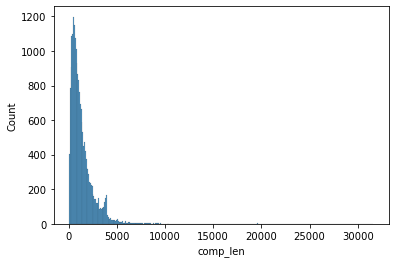

In [359]:
char_len_vis(df_clean)

<font color='blue'> Most of the complaint character lengths are under 5000 characters.</font>

In [360]:
#renaming the columns
df_clean.columns=['complaints','lemmatized_complaints','complaint_POS_removed']
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...","[morning, name, xxxx, xxxx, stop, bank, cardme..."
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...","[card, agent, anniversary, date, agent, inform..."
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, however, fraud...","[card, application, identity, consent, service..."
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, trying, to, book, a, xxxx, xxxx, t...","[xxxx, ticket, offer, ticket, reward, card, in..."
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...","[son, check, chase, account, fund, chase, acco..."
...,...,...,...
21067,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...","[chase, card, customer, decade, solicitation, ..."
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...","[credit, card, provider, claim, purchase, prot..."
21069,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...","[pay, risk, consumer, wa, chase, year, banking..."
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...","[credit, chase, credit, card, chase, freedom, ..."


#### Find the top 40 words by frequency among all the articles after processing the text.

In [361]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
all_cleaned_complaints = df_clean.complaint_POS_removed.tolist()
flatten_word_list = [word for complaint in all_cleaned_complaints for word in complaint]
cleaned_word_df = pd.DataFrame(flatten_word_list, columns=['cleaned_word_list'])

In [362]:
#Top 40 words in processed text
cleaned_word_df.cleaned_word_list.value_counts().head(40)

xxxx           87232
chase          48145
account        47279
credit         32598
card           29916
payment        21091
bank           16952
time           16006
day            12904
charge         12040
money          11922
loan           10863
check          10289
information     9640
letter          9602
fee             8947
transaction     8644
xxxxxxxx        8613
number          8584
month           8444
amount          8352
year            8265
customer        8153
mortgage        7960
balance         7762
company         7593
phone           7518
service         7459
report          7012
fund            6995
call            6681
fraud           6616
claim           6475
wa              6276
email           5803
business        5557
interest        5310
issue           5268
statement       5245
dispute         5079
Name: cleaned_word_list, dtype: int64

In [363]:
from wordcloud import WordCloud

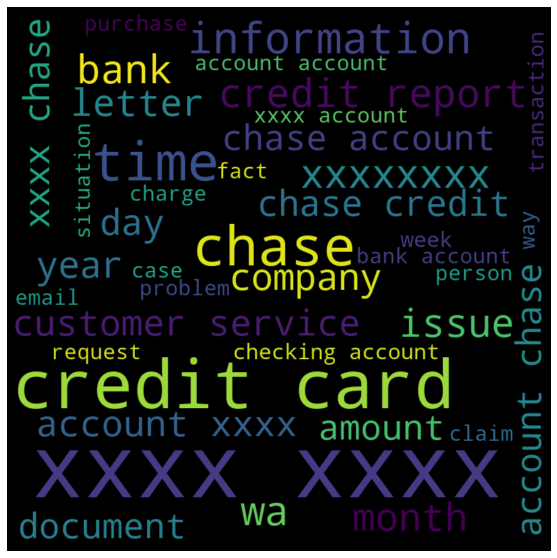

In [364]:
#top 40 words using word cloud
wordcloud = WordCloud(width=800, height=800, max_words=40).generate(' '.join(flatten_word_list))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [365]:
#Removing -PRON- from the text corpus
# df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [366]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
uni_dist = nltk.FreqDist(flatten_word_list)
# for k,v in fdist.items():
#     print (k,' ',v)
uni_dist.most_common(30)

[('xxxx', 87232),
 ('chase', 48145),
 ('account', 47279),
 ('credit', 32598),
 ('card', 29916),
 ('payment', 21091),
 ('bank', 16952),
 ('time', 16006),
 ('day', 12904),
 ('charge', 12040),
 ('money', 11922),
 ('loan', 10863),
 ('check', 10289),
 ('information', 9640),
 ('letter', 9602),
 ('fee', 8947),
 ('transaction', 8644),
 ('xxxxxxxx', 8613),
 ('number', 8584),
 ('month', 8444),
 ('amount', 8352),
 ('year', 8265),
 ('customer', 8153),
 ('mortgage', 7960),
 ('balance', 7762),
 ('company', 7593),
 ('phone', 7518),
 ('service', 7459),
 ('report', 7012),
 ('fund', 6995)]

In [367]:
#Print the top 10 words in the unigram frequency
[item[0] for item in uni_dist.most_common(10)]

['xxxx',
 'chase',
 'account',
 'credit',
 'card',
 'payment',
 'bank',
 'time',
 'day',
 'charge']

In [368]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bgram = nltk.bigrams(flatten_word_list)
bi_dist = nltk.FreqDist(bgram)
bi_dist.most_common(30)

[(('xxxx', 'xxxx'), 23358),
 (('credit', 'card'), 12837),
 (('credit', 'report'), 3872),
 (('account', 'xxxx'), 3106),
 (('customer', 'service'), 3083),
 (('chase', 'credit'), 3012),
 (('xxxx', 'chase'), 2982),
 (('chase', 'account'), 2910),
 (('account', 'chase'), 2828),
 (('checking', 'account'), 2764),
 (('account', 'account'), 2489),
 (('xxxx', 'account'), 2246),
 (('bank', 'account'), 2210),
 (('debit', 'card'), 2023),
 (('chase', 'xxxx'), 1916),
 (('credit', 'score'), 1715),
 (('number', 'xxxx'), 1679),
 (('card', 'account'), 1674),
 (('card', 'xxxx'), 1661),
 (('xxxx', 'credit'), 1653),
 (('phone', 'call'), 1641),
 (('account', 'credit'), 1556),
 (('xxxx', 'payment'), 1493),
 (('payment', 'xxxx'), 1453),
 (('card', 'chase'), 1443),
 (('money', 'account'), 1418),
 (('chase', 'bank'), 1321),
 (('credit', 'bureau'), 1294),
 (('interest', 'rate'), 1292),
 (('business', 'day'), 1253)]

In [369]:
#Print the top 10 words in the bigram frequency
bigram_words = []
for k,v in bi_dist.items():
    bigram_words.extend([k[0],k[1]])
bigram_df = pd.DataFrame(bigram_words)
bigram_df.value_counts().head(10)

xxxx       6931
chase      5014
account    4306
credit     3092
time       3076
bank       3070
card       3000
payment    2996
money      2541
day        2478
dtype: int64

In [370]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
tgram = nltk.trigrams(flatten_word_list)
tri_dist = nltk.FreqDist(tgram)
tri_dist.most_common(30)

[(('xxxx', 'xxxx', 'xxxx'), 5997),
 (('chase', 'credit', 'card'), 2099),
 (('credit', 'card', 'account'), 1073),
 (('_', '_', '_'), 1035),
 (('credit', 'card', 'company'), 983),
 (('xxxx', 'credit', 'card'), 756),
 (('account', 'xxxx', 'xxxx'), 741),
 (('xxxx', 'xxxx', 'chase'), 724),
 (('credit', 'card', 'xxxx'), 688),
 (('credit', 'card', 'chase'), 622),
 (('xxxx', 'xxxx', 'account'), 572),
 (('inquiry', 'credit', 'report'), 549),
 (('credit', 'card', 'credit'), 529),
 (('account', 'credit', 'card'), 476),
 (('xxxx', 'xxxx', 'credit'), 436),
 (('card', 'credit', 'card'), 429),
 (('payment', 'xxxx', 'xxxx'), 421),
 (('xxxx', 'xxxx', 'payment'), 416),
 (('name', 'xxxx', 'xxxx'), 409),
 (('chase', 'xxxx', 'xxxx'), 398),
 (('card', 'xxxx', 'xxxx'), 392),
 (('credit', 'report', 'credit'), 360),
 (('charge', 'credit', 'card'), 358),
 (('credit', 'reporting', 'agency'), 351),
 (('customer', 'service', 'representative'), 348),
 (('number', 'xxxx', 'xxxx'), 341),
 (('credit', 'reporting', 'ac

In [371]:
#Print the top 10 words in the trigram frequency
trigram_words = []
for k,v in tri_dist.items():
    trigram_words.extend([k[0],k[1]])
trigram_df = pd.DataFrame(trigram_words)
trigram_df.value_counts().head(10)

xxxx       66284
chase      48373
account    42331
card       24682
payment    21955
time       21498
bank       20350
credit     18980
day        15857
money      15099
dtype: int64

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [372]:
df_clean.columns=['complaints','lemmatized_complaints','Complaint_clean']

In [382]:
#Convert 'Complaint_clean' from list to str.
df_clean['Complaint_clean'] = df_clean.Complaint_clean.apply(lambda x: ' '.join(x))

In [383]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [384]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,Complaint_clean
0,Good morning my name is XXXX XXXX and I apprec...,"[good, morning, my, name, is, xxxx, xxxx, and,...",morning name stop bank cardmember service de...
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,"[i, upgraded, my, xxxx, xxxx, card, in, and, w...",card agent anniversary date agent information ...
2,Chase Card was reported on XX/XX/2019. However...,"[chase, card, wa, reported, on, however, fraud...",card application identity consent service cred...
3,"On XX/XX/2018, while trying to book a XXXX XX...","[on, while, trying, to, book, a, xxxx, xxxx, t...",ticket offer ticket reward card information o...
4,my grand son give me check for {$1600.00} i de...,"[my, grand, son, give, me, check, for, i, depo...",son check chase account fund chase account mon...
...,...,...,...
21067,After being a Chase Card customer for well ove...,"[after, being, a, chase, card, customer, for, ...",chase card customer decade solicitation credit...
21068,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...","[on, wednesday, xxxxxxxx, i, called, chas, my,...",credit card provider claim purchase protection...
21069,I am not familiar with XXXX pay and did not un...,"[i, am, not, familiar, with, xxxx, pay, and, d...",pay risk consumer wa chase year banking mercha...
21070,I have had flawless credit for 30 yrs. I've ha...,"[i, have, had, flawless, credit, for, yr, ive,...",credit chase credit card chase freedom proble...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 



#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



